In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
from SimPEG.utils.code_utils import validate_ndarray_with_shape
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = 2
    segmentation_model: geoseg.SamClassificationModel=None
    method = 'bound_box'
    reg_rots = np.zeros(0)
    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        if self.count == self.seg_iter:
            
            # self.reg[1][1].update_gradients(self.opt.xc)
            masks = self.segmentation_model.fit(self.opt.xc)

            mesh = self.segmentation_model.mesh
            reg_dirs = [np.identity(2) for _ in range(mesh.nC)]
            sqrt2 = np.sqrt(2)
            reg_rots = np.zeros(mesh.nC)

            # loop through masks and assign rotations
            for ii in range(1, len(masks) - 2):
                seg_data = masks[ii]['segmentation']
                seg_data = np.flip(seg_data)
                # Find the coordinates of the object pixels
                object_pixels = np.argwhere(seg_data == 1)

                # Apply PPCA to determine orientation
                if len(object_pixels) > 1:
                    # Standardize the data
                    scaler = StandardScaler()
                    object_pixels_std = scaler.fit_transform(object_pixels)

                    # Apply PPCA
                    pca = PCA(n_components=2)
                    pca.fit(object_pixels_std)

                    # The first principal component (eigenvector) will represent the orientation
                    orientation_vector = pca.components_[0]

                    # Compute the angle of the orientation vector (in degrees)
                    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

                    print(f"Orientation angle (degrees): {angle_degrees}")
                    angle_radians = angle_degrees * np.pi / 180

                    # Create the 2x2 rotation matrix
                    # rotation_matrix = np.array([
                    #     [np.cos(angle_radians), -np.sin(angle_radians)],
                    #     [np.sin(angle_radians), np.cos(angle_radians)]
                    # ])
                    
                    rotation_matrix = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
                    alphas = np.ones((mesh.n_cells, mesh.dim))
                    # check for rotation application method
                    if self.method == 'bound_box':
                        bbox_mask = self.segmentation_model.get_bound_box_indicies(ii)

                        flatten = bbox_mask # masks[ii]['segmentation'].flatten(order='F')
                        reshape = flatten.reshape(mesh.shape_cells, order='F')

                        plt.imshow(reshape.T)
                        plt.title(f'mask: {ii + 1}')
                        plt.gca().invert_yaxis()
                        # plt.plot([x0, x1], [y0, y1], 'ok')
                        plt.show()

                        for ii in range(mesh.nC):

                            if bbox_mask[ii] == 1:
                                print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                reg_dirs[ii] = rotation_matrix
                                alphas[ii] = [25, 150]
                                reg_rots[ii] = angle_degrees
                        #         alphas[ii] = [150, 25]
                        # reg_dirs[bbox_mask] = [rotation_matrix] * int(bbox_mask.sum())
                    else:
                        reg_dirs[seg_data] = [rotation_matrix] * seg_data.sum()

                    reg_dirs = validate_ndarray_with_shape(
                        "reg_dirs",
                        reg_dirs,
                        shape=[(mesh.dim, mesh.dim), ("*", mesh.dim, mesh.dim)],
                        dtype=float,
                    )
                    
                    reg_seg = geoseg.GeologicalSegmentation(

                        mesh, 
                        reg_dirs=reg_dirs,
                        alphas=alphas,
                        ortho_check=False,

                    )

                    reg_small = regularization.Smallness(
                        mesh=mesh,
                        reference_model=self.reg[0][1].reference_model,
                        )


                    self.reg = reg_small + reg_seg
                    self.reg.multipliers = np.r_[1e-5, 1000.0]
                    self.invProb.reg = self.reg
                    self.reg_rots = reg_rots

                else:
                    raise ValueError("Not enough object pixels to determine orientation.")


        
        self.count += 1


3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_329775/2138462038.py:44: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_329775/2138462038.py:72: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_329775/2138462038.py:76: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: Runtime

0.010011213936349366
0.44130588567901136
0.021341442973538072
0.04148879127924714


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

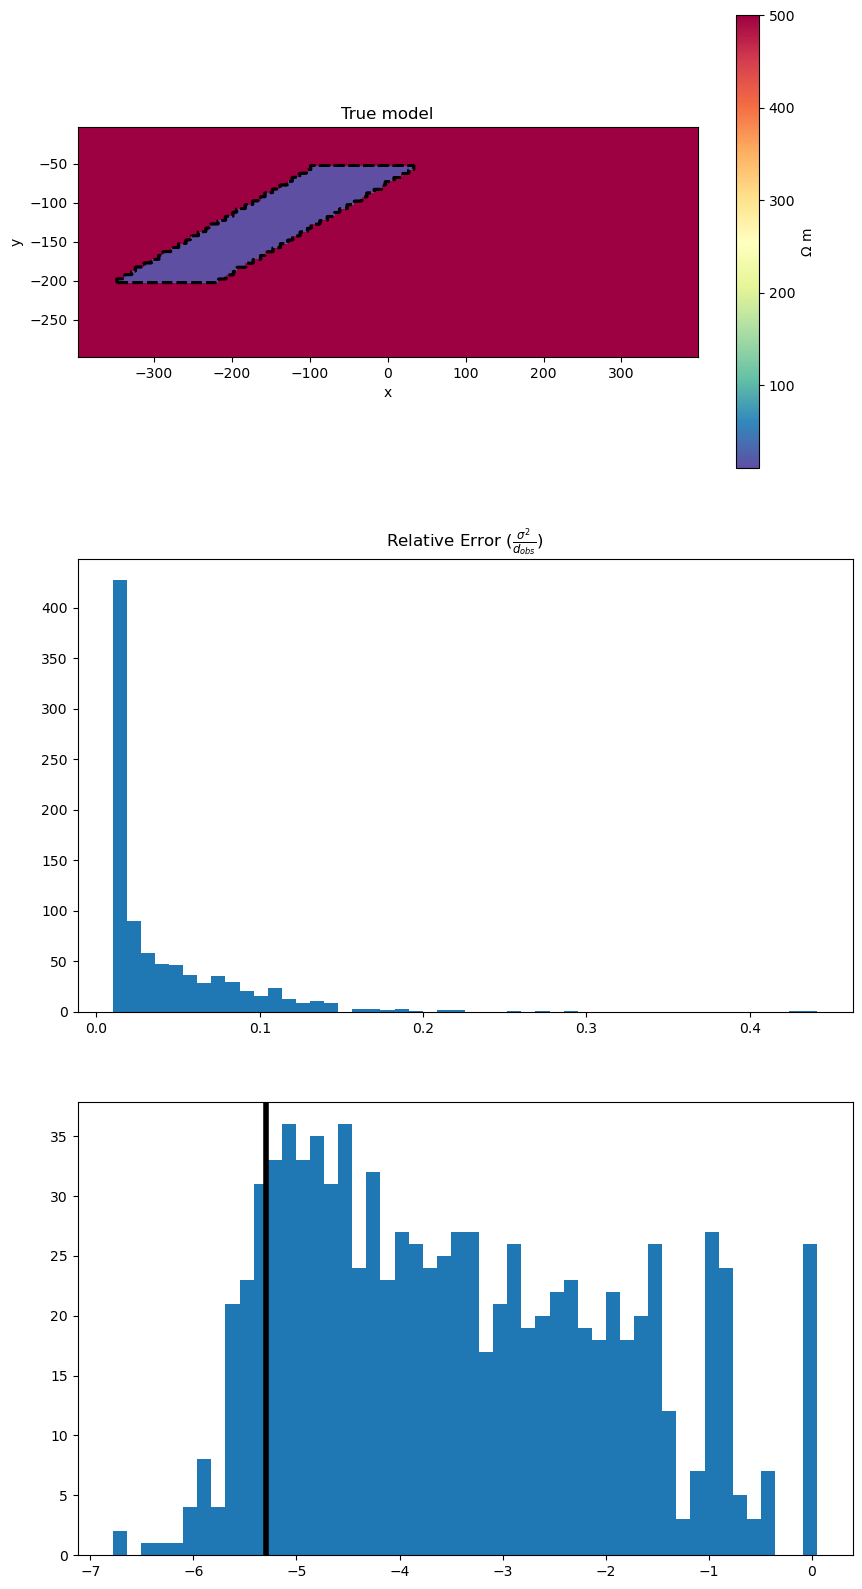

In [2]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=5e-4,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.06)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.1)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

In [3]:
np.quantile(np.abs(dc_data.dobs), 0.08)

0.004618572018097766

/tmp/ipykernel_329775/1915102650.py:52: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-4, everyIter=False)
/tmp/ipykernel_329775/1915102650.py:52: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-4, everyIter=False)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:332: UserWarning: There is no PGI regularization. Smallness target is turned off (TriggerSmall flag).
  getattr(r, ruleType)()


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  2.20e+05  0.00e+00  2.20e+05    9.67e+03      0              
geophys. misfits: 38786.2 (target 460.0 [False])


/tmp/ipykernel_329775/1904410579.py:72: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],


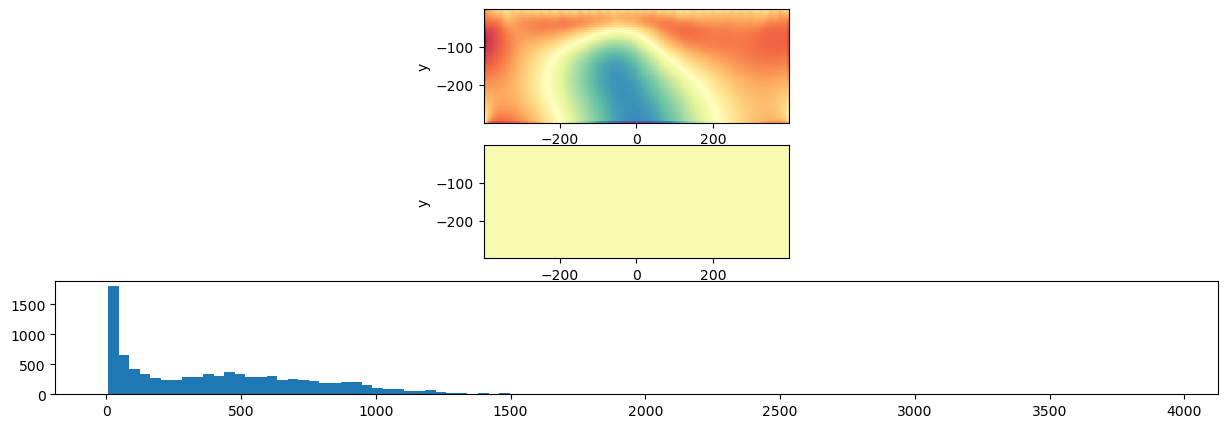

   1  5.00e-02  3.88e+04  5.41e+03  3.91e+04    7.45e+03      0              
geophys. misfits: 4722.0 (target 460.0 [False])


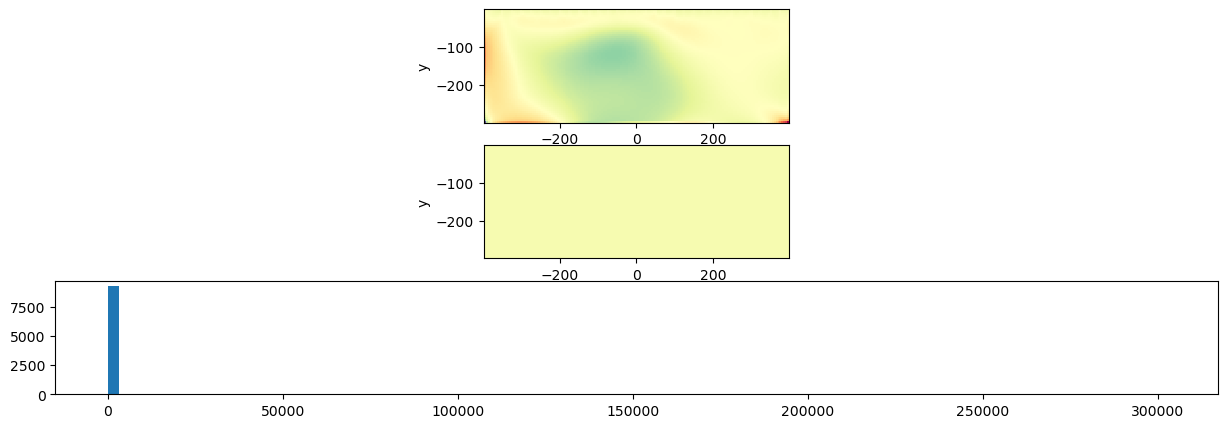

   2  2.50e-02  4.72e+03  3.77e+03  4.82e+03    9.79e+02      0              
geophys. misfits: 1907.7 (target 460.0 [False])


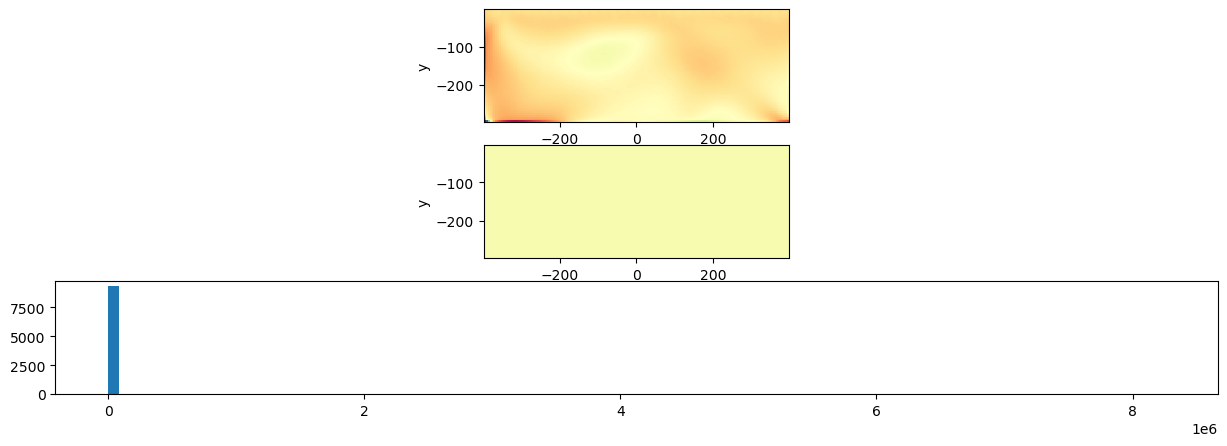

   3  1.25e-02  1.91e+03  5.04e+03  1.97e+03    4.21e+02      0   Skip BFGS  
geophys. misfits: 1171.2 (target 460.0 [False])


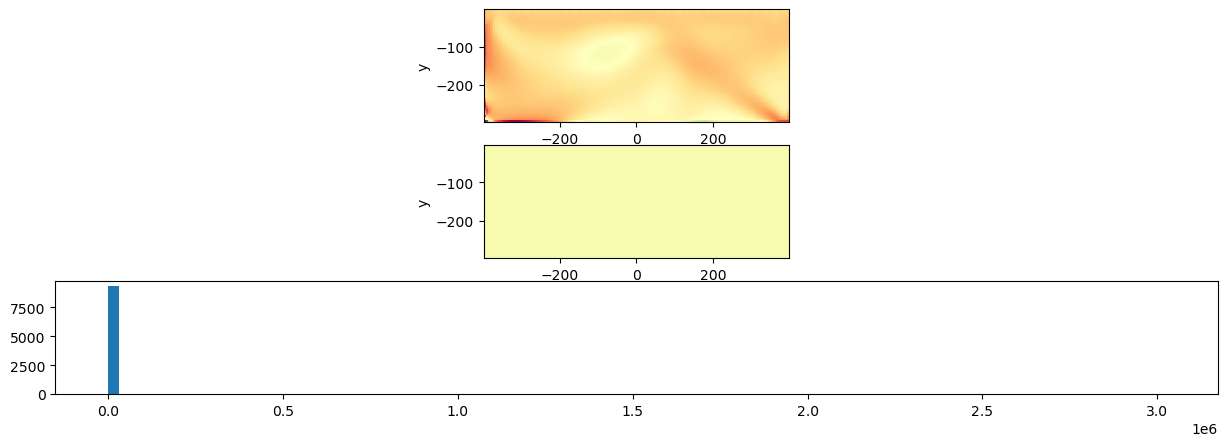

   4  6.25e-03  1.17e+03  4.95e+03  1.20e+03    3.88e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 14.000248122146747
geophys. misfits: 905.8 (target 460.0 [False])


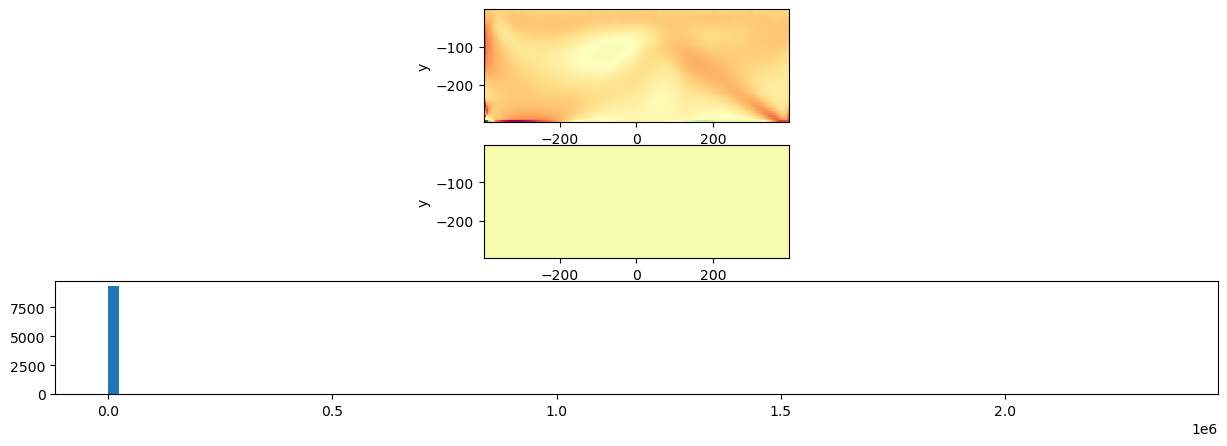

   5  1.56e-03  9.06e+02  1.16e+04  9.24e+02    2.47e+02      0              
geophys. misfits: 787.2 (target 460.0 [False])


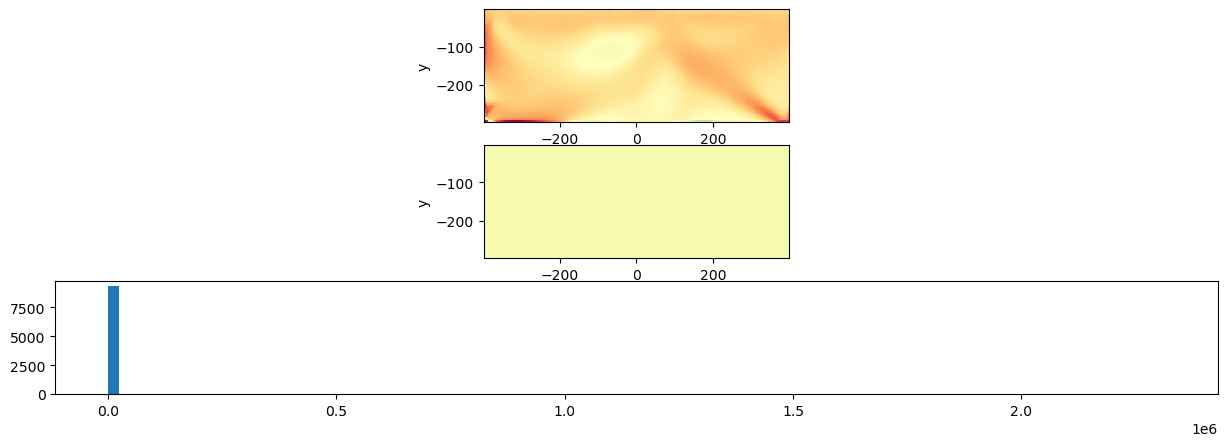

   6  1.04e-03  7.87e+02  1.39e+04  8.02e+02    2.12e+02      0              
geophys. misfits: 723.7 (target 460.0 [False])


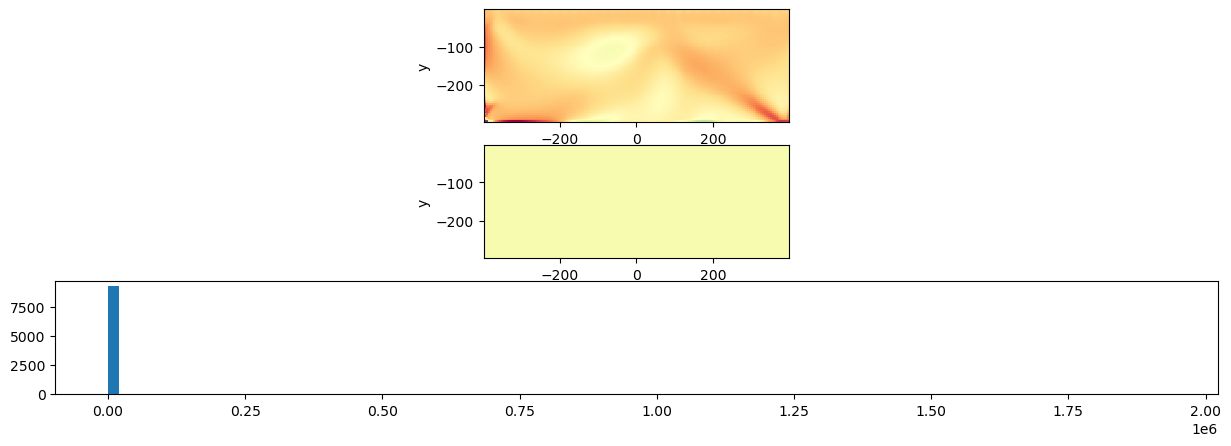

   7  7.22e-04  7.24e+02  1.66e+04  7.36e+02    1.58e+02      0              
geophys. misfits: 682.8 (target 460.0 [False])


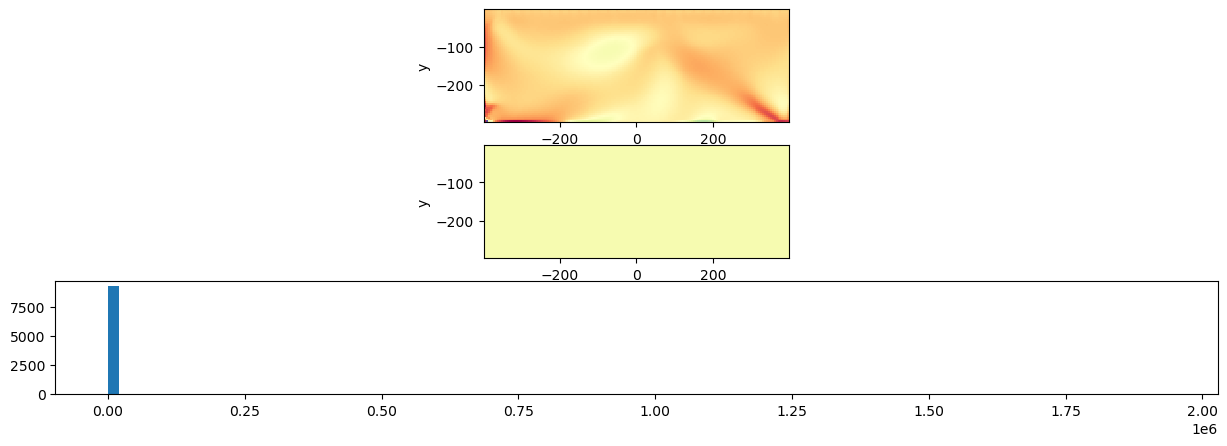

   8  5.14e-04  6.83e+02  1.95e+04  6.93e+02    1.45e+02      0              
geophys. misfits: 649.6 (target 460.0 [False])


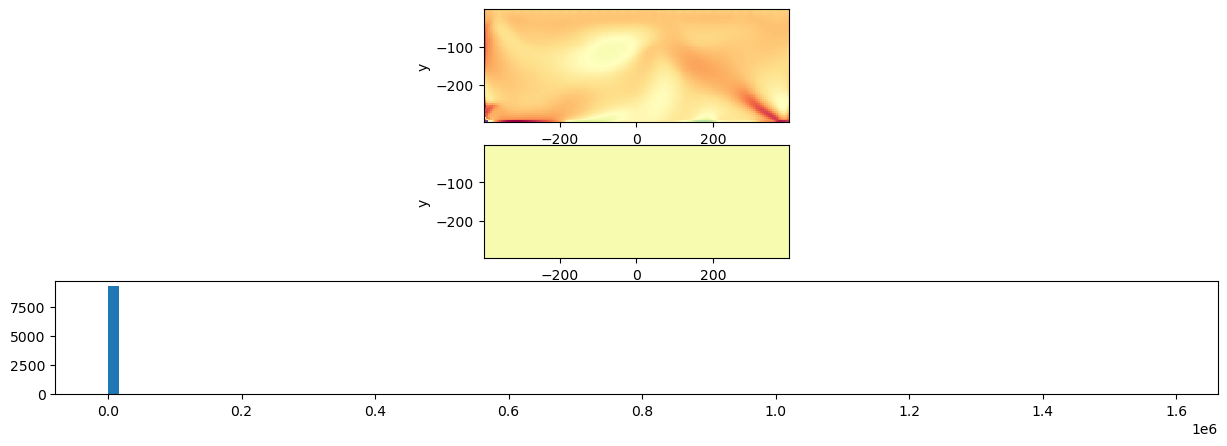

   9  3.75e-04  6.50e+02  2.30e+04  6.58e+02    1.29e+02      0              
geophys. misfits: 625.0 (target 460.0 [False])


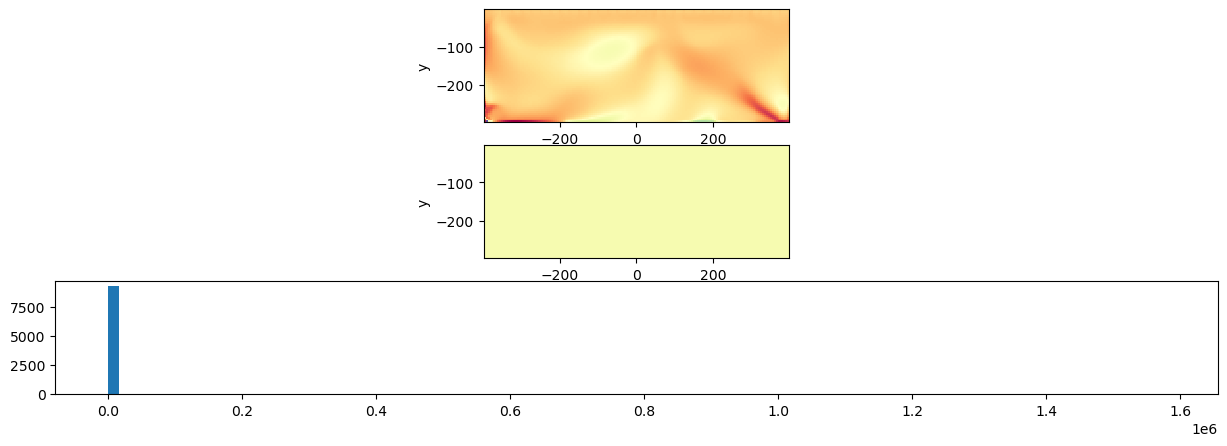

  10  1.39e-04  6.25e+02  2.65e+04  6.29e+02    1.11e+02      0              
geophys. misfits: 599.6 (target 460.0 [False])


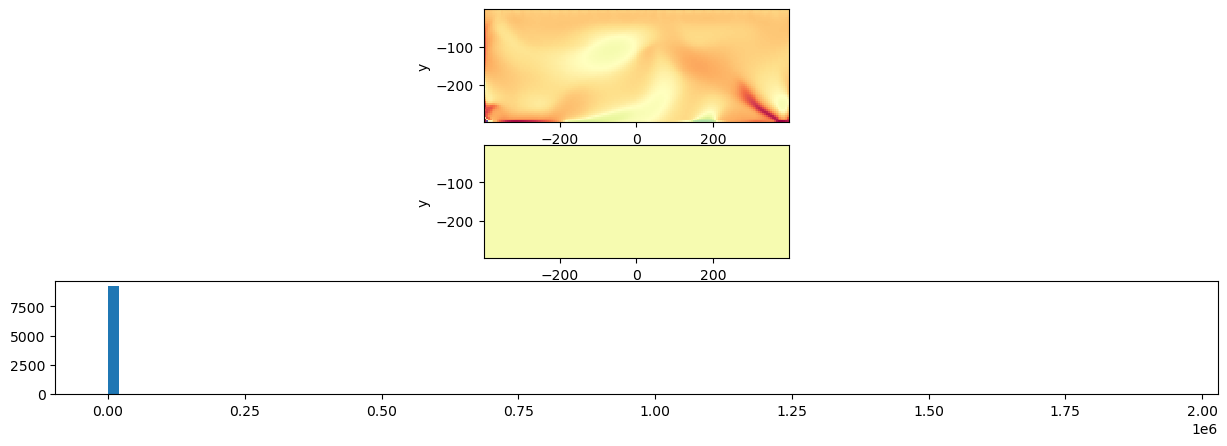

  11  1.06e-04  6.00e+02  3.08e+04  6.03e+02    1.22e+02      0              
geophys. misfits: 574.6 (target 460.0 [False])


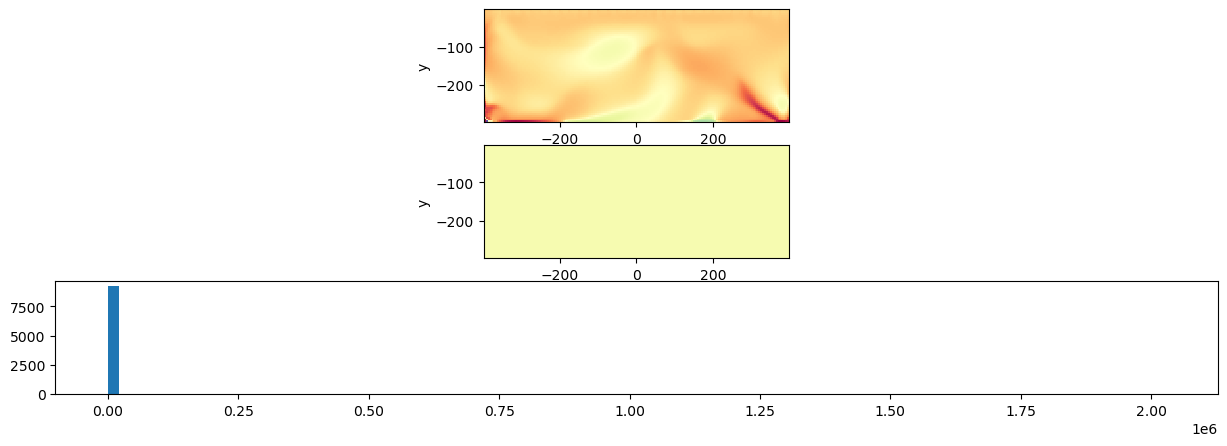

  12  8.19e-05  5.75e+02  3.46e+04  5.77e+02    8.87e+01      0              
geophys. misfits: 555.8 (target 460.0 [False])


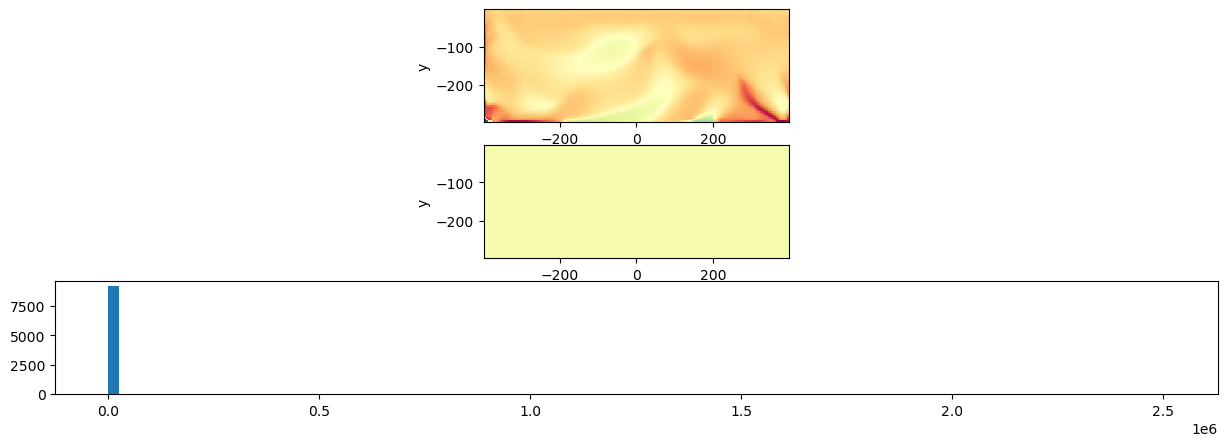

In [4]:
# --------------------------------------------------------------------------

# setup the inversion

#

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

reg_mean = regularization.Sparse(
    mesh, 
    active_cells=actcore,
    norms=[1, 1 ,1],
    mapping=idenMap,
    reference_model=m0
)

reg_mean.reference_model_in_smooth = True  # Include reference model in smoothness

p = 0
qx = 1
qz = 1
reg_mean.norms = [p, qx, qz]

# Reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=25, minGNiter=1, chifact_start=2.0
)


# Optimization
opt = optimization.ProjectedGNCG(maxIter=15, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)
betaIt = directives.BetaSchedule(coolingFactor=2, coolingRate=5)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
# MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)

plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-4, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            updateSensW,
                                            # update_sam,
                                            #  petrodir,
                                            update_IRLS,
                                            targets, betaIt,
                                            # MrefInSmooth,
                                            plot_iter_mref,
                                            #  save_pgi,
                                            update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")


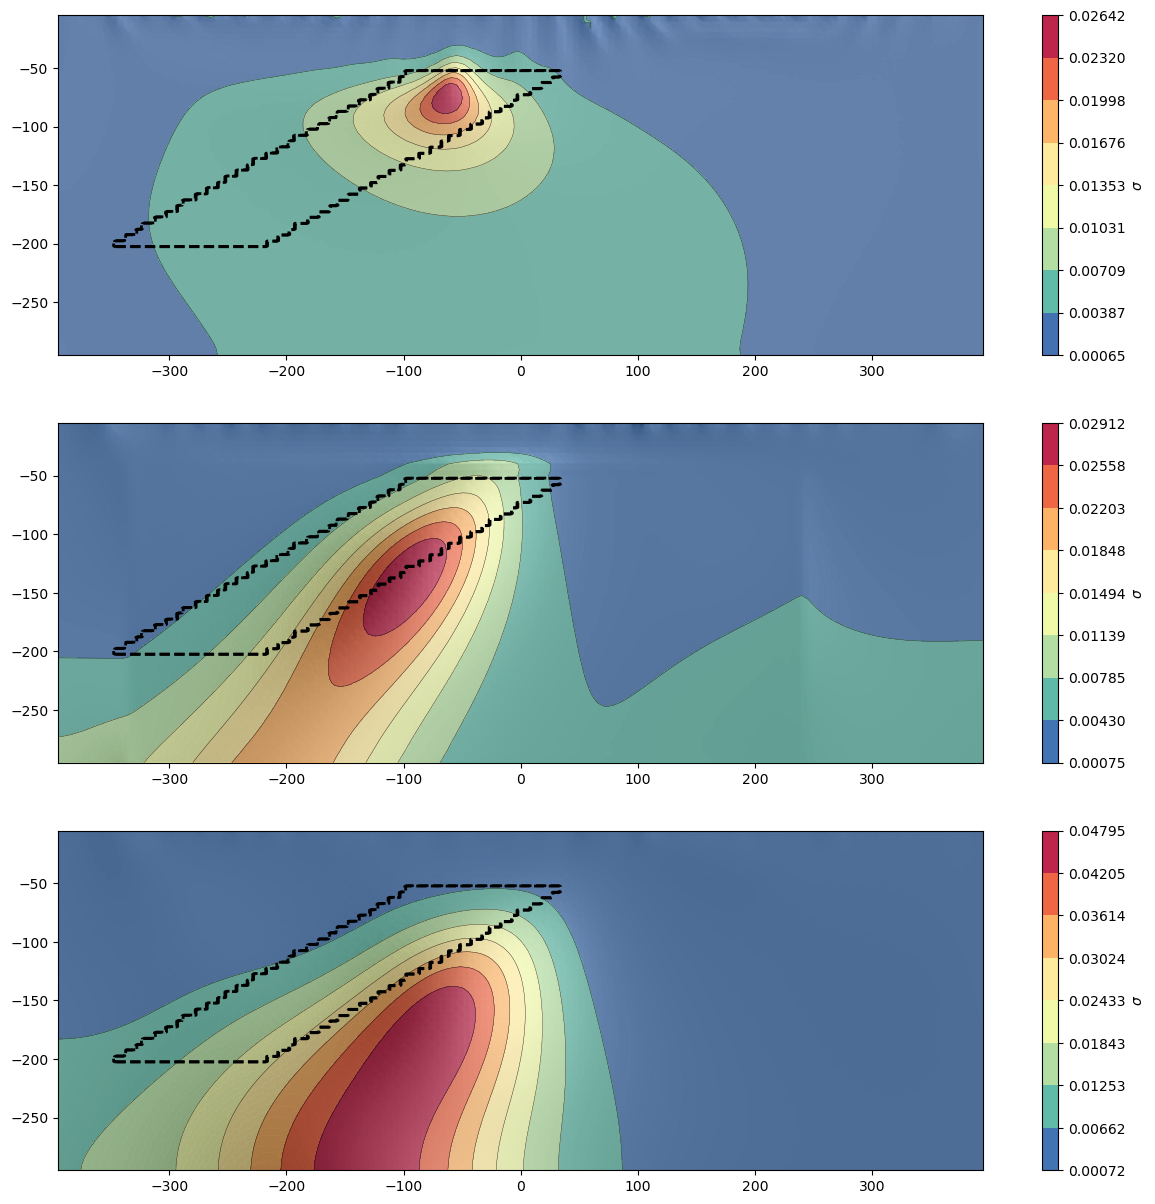

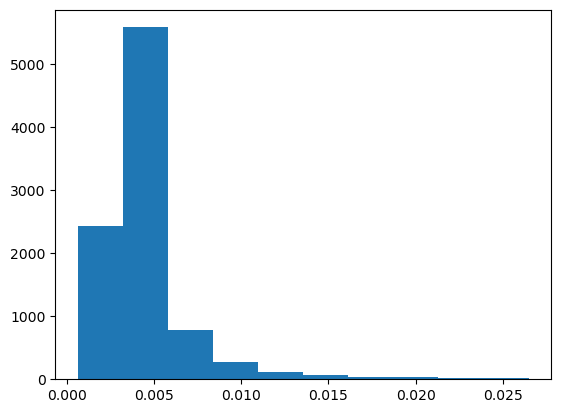

In [13]:
# dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/guided/model_11.npy"))
dip_model2 =  np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_30.npy"))
dip_model3 = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/L2/model_10.npy"))
dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_4.npy"))

fig, ax = plt.subplots(3,1, figsize=(15,15))
clim = [1 / 1000, 1/200]
mm2 = utils.plot2Ddata(

    meshCore.gridCC, dip_model3,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[2],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm2[0], label=r'$\sigma$')

mm = utils.plot2Ddata(

    meshCore.gridCC, dip_model,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm[0], label=r'$\sigma$')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

mm1 = utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm1[0], label=r'$\sigma$')



# plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

# print(reg_org(dip_model))
# print(reg_mean(dip_model))

# plt.hist(dip_model2)
plt.hist(dip_model)
plt.show()